# Laboratorio de Introducción al Procesamiento de Lenguaje Natural 2017

#### Número de grupo: 13
#### Integrantes:
- Giovani Rondán, CI: 4.528.997-6
- Santiago Behak, CI: 5.019.450-0

## 1- Importación de los tweets.

Comenzaremos importando los tweets provenientes del archivo "corpus_humor_training.csv" usando la librería Pandas:

In [1]:
import pandas
import csv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
import re
import freeling
from pylab import *
import numpy as np
from nltk.corpus import stopwords
import IPython.display as disp

corpus = pandas.read_csv("corpus_humor_training.csv",encoding='utf-8')

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Los registros de este corpus están compuestos por varios datos además del propio texto del tweet. A continuación mostraremos la estructura del corpus y algunos de los tweets (que se encuentran en el atributo "text") a modo de ejemplo:

In [2]:
print(corpus.columns)
print "\n"
for text in corpus['text'][:7]:
    print(text + '\n')

Index([u'id', u'text', u'account_id', u'n', u'1', u'2', u'3', u'4', u'5'], dtype='object')


-La semana pasada mi hijo hizo un triple salto mortal desde 20 metros de altura - ¿Es trapecista? -Era :(

-Yo ya voy por mi segundo millón de dólares... -¿!Ah, si!? -Es que el primero nunca lo hice... #fb

-Ayer fue mi cumpleaños y no me felicitaste - ¡FéÉLíCÍDáÁDÉéS! - ¿Qué haces? -Felicitarte con retraso.

No es flojera, es un estado de ahorro de energía corporal :)

- ¿Cómo te fue en matemática? -Vos sabes que soy muy pacífica - ¿Y eso qué tiene que ver? -No me gustan los problemas jajaja -Castigada - :(

"El pesimista se queja del viento; el optimista espera que cambie; el realista ajusta las velas" Feliz miércoles.

-¿Y tú desde cuando llevas pendiente? 
-Desde que mi mujer se lo encontró en el coche y le dije que era mío...



A continuación porocedemos a analizar las características del corpus obtenido, para esto obtendremos algunos datos básicos tales como la cantidad total de tweets, la cantidad de atributos de los que disponemos, la cantidad de calificaciones de los 10 tweets más calificados y la cantidad total de calificaciones.

In [3]:
cantTweets = len(corpus)
cantAtributos = len(corpus.columns)

# Imprimimos la cantidad total de tweets y la cantidad de atributos
print ("Cantidad de Tweets en el corpus: " + str(cantTweets))
print ("Cantidad de atributos en el corpus: " + str(cantAtributos))

# Imprimimos la cantidad de calificaciones de los 10 tweets mas calificados y la cantidad total de calificaciones
totalCalificaciones = 0
contador = 0
corpus["cantCalificaciones"] = [0]*len(corpus)
for i in range(0, 12106):
    calificacionesTweet =corpus.loc[i, "n"] + corpus.loc[i, "1"]  + corpus.loc[i, "2"] + corpus.loc[i, "3"] + corpus.loc[i, "4"] + corpus.loc[i, "5"]
    totalCalificaciones += calificacionesTweet
    corpus.loc[i, "cantCalificaciones"] = calificacionesTweet

print ("Lista de los diez tweets con más calificaciones:\n")
disp.display(corpus.sort_values(by = ['cantCalificaciones'], ascending = False).head(10))

Cantidad de Tweets en el corpus: 12106
Cantidad de atributos en el corpus: 9
Lista de los diez tweets con más calificaciones:



,id,text,account_id,n,1,2,3,4,5,cantCalificaciones
5879,445969156437852161,"—¿A dónde vas tan maquillada? —A una fiesta, m...",1518218509,2,6,3,2,6,2,21
8158,446273545304162304,"JAJAJAJAJAJA ¿TE ACUERDAS CUANDO... ah, no, tú...",229144847,13,2,1,4,0,0,20
10238,446423336831053824,"""Tu invades mi cabeza"" —Juanita, 10 años, tien...",229144847,4,6,4,3,2,0,19
11728,464188098780618752,#Chistetipico,124053720,17,0,0,0,1,0,18
7849,447042317480763393,"""Es imposible"" dijo el orgullo; ""es arriesgado...",1518218509,6,6,1,1,3,0,17
8966,448704341365366784,-Tenemos una relación seria. -¿Lleváis mucho t...,1518218509,1,2,4,3,3,4,17
1117,446934186889211905,"Hablo 3 idiomas: español, sarcasmos e indirectas.",1518218509,6,4,1,4,0,1,16
7037,445481775133777921,Molestar a alguien solo porque te gusta ver co...,1518218509,14,1,0,1,0,0,16
9273,445669834211069952,A mi también me castigaron por reírme mientras...,1518218509,11,3,0,0,2,0,16
4306,447613590992732160,"—En mis tiempos... —Sí, sí abuela, como digas,...",1518218509,4,1,3,4,2,1,15


Otro dato que puede resultar interesante es la cantidad de calificaciones por valor (las calificaciones no humorísiticas serán contadas con el 0).

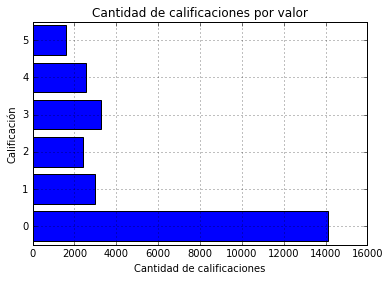

In [4]:
%matplotlib inline

# Se realiza una gráfica de cantidad de comentarios en función de su clasificación
calificacionesPorValor = [corpus["n"].sum(), corpus["1"].sum(), corpus["2"].sum(), corpus["3"].sum(), corpus["4"].sum(), corpus["5"].sum()]
valoresCalificaciones = ["0", "1", "2", "3", "4", "5"]
pos = arange(len(valoresCalificaciones)) + 0.5 

figure(1)
barh(pos,calificacionesPorValor, align='center')
yticks(pos, valoresCalificaciones)
xlabel('Cantidad de calificaciones')
ylabel(u'Calificación')
title(u'Cantidad de calificaciones por valor')
grid(True)
show()

Como se puede ver en la gráfica la mayoría de las calificaciones corresponden al valor 0, o sea, como calificaciones no humorísticas.

## 2- Preprocesmiento de los datos

En primer lugar procederemos a eleminar las columnas del corpus que consideramos innecesarias. Eliminaremos las columnas tanto de la id del tweet como la de la id del usuario. La id del tweet es un número autogenerado que no aporta información relevante ya que es completamente aleatoria y la id del usuario, si bien puede llegar a relacionarse con usuarios que tienden a emitir tweets de carácter más o menos humorístico, no es un factor concluyente para determinar el nivel de humor de un tweet particular (un mismo usuario puede hacer tweets humorísticos y no humorísticos).

In [5]:
if "id" in corpus.columns:
    del corpus["id"]
if "account_id" in corpus.columns:
    del corpus["account_id"]
print corpus.columns


Index([u'text', u'n', u'1', u'2', u'3', u'4', u'5', u'cantCalificaciones'], dtype='object')


Una vez filtradas las columnas del corpus nos disponemos a filtrar los tweets que tienen menos de tres calificaciones dado que los mismos no cuentan con una cantidad significativa de calificaciones como para ser evaluados. Además se eliminarán los hashtags de los textos de los tweets como se pide en la letra y agregaremos una nueva columna que determina si un tweet es humorístico en función del número de calificaciones no humorísticas en relación al total de calificaciones del tweet. Si la cantidad de calificaciones humorísticas es mayor o igual a la suma del resto de calificaciones el tweet se considerará no humorístico.

In [6]:
corpus["humoristico"] = [False]*len(corpus)
corpus_filtrado = pandas.DataFrame(columns = ['text', 'n', '1', '2', '3', '4', '5', 'humoristico', 'cantCalificaciones'])
#corpus_filtrado = corpus[corpus.n + corpus.columns[4] + corpus.columns[5] + corpus.columns[6] + corpus.columns[7] + corpus.columns[8] >= 3]
total = 0
for i in range(0, 12106):
    contador = corpus.loc[i, "cantCalificaciones"]
    #eliminamos los hashtags
    corpus.loc[i, "text"] = re.sub(r"#\S+\s*", "", corpus.loc[i, "text"])
    #definimos si un tweet es humoristico o no segun los votos
    if(contador/2 >= corpus.loc[i, "n"]):
        corpus.loc[i, "humoristico"] = True
    #filtramos los tweets que tienen menos de 3 votos
    if contador >= 3:
        corpus_filtrado.loc[total] = [corpus.loc[i, "text"], corpus.loc[i, "n"], corpus.loc[i, "1"], corpus.loc[i, "2"], corpus.loc[i, "3"], corpus.loc[i, "4"], corpus.loc[i, "5"], corpus.loc[i, "humoristico"], corpus.loc[i, "cantCalificaciones"]]
        total += 1
        
#columna 3 -> n, 4 -> 1, 5 -> 2, 6 -> 3, 7 -> 4, 8 -> 5

disp.display(corpus_filtrado.loc[0:10, :])
print "Cantidad de tweets que quedan en el corpus luego del filtrado: " + str(len(corpus_filtrado))

,text,n,1,2,3,4,5,humoristico,cantCalificaciones
0,-La semana pasada mi hijo hizo un triple salto...,0,1,1,0,0,1,True,3
1,-Yo ya voy por mi segundo millón de dólares......,2,1,0,0,0,0,False,3
2,-Ayer fue mi cumpleaños y no me felicitaste - ...,0,1,1,1,0,1,True,4
3,"No es flojera, es un estado de ahorro de energ...",1,1,1,0,0,0,True,3
4,- ¿Cómo te fue en matemática? -Vos sabes que s...,2,0,0,1,0,0,False,3
5,"-Compadre, su hija antes me daba como por las ...",1,1,0,0,1,0,True,3
6,Había una vez una tortuguita que fue a su prim...,1,2,1,0,0,0,True,4
7,"Una novia que sea tan delicada como Neymar, es...",2,0,0,0,1,0,False,3
8,¿Qué le dice el Nesquik a la leche? ¡Te voy a ...,2,1,0,0,1,0,True,4
9,Si oscar se queda me pego un tiro con un banan...,6,1,1,0,1,0,False,9


Cantidad de tweets que quedan en el corpus luego del filtrado: 3438


## 3- Separación de los datos en conjunto de train y test

A continuación dividiremos el corpus restante en un conjunto de train y en otro de test. En principio usaremos un 80% de los datos para el entrenamiento y un 20% para el testeo.

In [7]:
corpus_train, corpus_test = train_test_split(corpus_filtrado, test_size=0.2)

print ("Cantidad de tweets en el conjunto de entrenamiento: " + str(len(corpus_train)))
print ("Cantidad de tweets en el conjunto de testeo: " + str(len(corpus_test)))

Cantidad de tweets en el conjunto de entrenamiento: 2750
Cantidad de tweets en el conjunto de testeo: 688


## 4- Clasificador binario con tokenizador y POS tag de Freeling

Una vez separados el conjunto de train y test procedemos a tokenizar los tweets provenientes del conjunto train. Para esto usaremos la librería Freeling y NLTK

### 4.1- Tokenización

KeyError: 'the label [8] is not in the [index]'

In [29]:
from subprocess import Popen, PIPE, STDOUT

os.environ["ANALYZER"] = "/home/santiago/Descargas/FreeLing-4.0/src/main"
os.environ["FREELINGSHARE"] = "/home/santiago/Descargas/FreeLing-4.0/data/es"
comando = os.environ["ANALYZER"] + "/analyzer -f " + "/home/santiago/Descargas/FreeLing-4.0/data"

def POS_tagging(datos, largo):
    listaTuplas = []
    
    # Retorna una lista de tuplas. 
    # Cada tupla posee un diccionario (dict) palabra-frecuencia del comentario y la clasificación asociada
    # En otras palabras [(dict1, clasificacion1),(dict2, clasificacion2), ... ]

    # Se recorren los comentarios y para cada uno de ellos se tokeniza con nltk
    for i in range(1, len(datos)):
        try:
            # Se crea el diccionario asociado al comentario
            dic = {}
            
            # Por cada palabra retornada de la tokenizacion del comentario
            p = Popen(comando, shell = True, stdout=PIPE, stdin=PIPE, stderr=STDOUT)
            stdout = p.communicate(input=datos.loc[i, "text"].encode('ascii','ignore'))[0]
            for linea in stdout.decode().split('\r\n'):
                print linea
                token = linea.split(' ')
                tag = token[2]
                palabra = token[0]
                print i
                print palabra
                
                if((tag[0:1] != 'F') and (tag[0:2] != 'RG') and (tag[0:2] != 'DP') and (tag[0:2] != 'DT') and (tag[0:2] != 'DE') 
                    and (tag[0:2] != 'DA') and (tag[0:1] != 'N') and (tag[0:2] != 'RG') and (tag[0:2] != 'PP') and (tag[0:2] != 'PD')
                    and (tag[0:2] != 'PX') and (tag[0:2] != 'PT') and (tag[0:2] != 'PR') and (tag[0:2] != 'PE') and (tag[0:1] != 'I')
                    and (tag[0:1] != 'S') and (tag[0:1] != 'Z') and (tag[0:1] != 'W')):

                    # Si la palabra está en el diccionario del comentario, se aumenta la frecuencia
                    # En caso contrario se la pone en el diccionario con valor 1
                    if(palabra.lower() in dic): 
                        dic[palabra.lower()] = dic[palabra.lower()] + 1
                    else:
                        dic[palabra.lower()] = 1

                    # Luego de tokenizado el comentario, se agrega una tupla a la lista que contendrá
                    # el diccionario de frecuencias y la clasificaion asociada al comentario
            listaTuplas.insert(i,(dic,datos.loc[i, "humoristico"]))
        except:
            print "explote"

    return listaTuplas

datos_test_tokenizados_pos_tagging = POS_tagging(corpus_train, len(corpus_filtrado))

ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

3
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

4
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

5
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

6
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

7
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

8
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

9
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

10
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

11
ANALYZE

ANALYZER: Tokenizer requested, but it was not instantiated in config options.

114
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

115
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

116
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

117
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

119
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

120
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

121
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

122
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

123
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

124
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in 

ANALYZER: Tokenizer requested, but it was not instantiated in config options.

226
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

227
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

228
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

229
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

230
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

231
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

233
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

234
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

235
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

236
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instanti

explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

338
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

340
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

342
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

343
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

344
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

345
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

346
ANALYZER:
explote
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

349
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

351
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

352
ANALYZER:
ANALYZER: Tokenizer re

ANALYZER: Tokenizer requested, but it was not instantiated in config options.

448
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

449
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

450
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

451
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

452
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

453
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

454
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

455
ANALYZER:
explote
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

458
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

459
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instanti

ANALYZER: Tokenizer requested, but it was not instantiated in config options.

563
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

565
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

566
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

567
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

568
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

570
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

571
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

572
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

574
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

575
ANALYZER:
ANALYZER: Tokenizer requested, but it was not 

ANALYZER: Tokenizer requested, but it was not instantiated in config options.

675
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

676
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

677
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

678
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

679
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

680
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

682
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

683
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

684
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

685
ANALYZER:
explote
explote
explote
ANALYZER: Tokenizer requested, but it 

explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

792
ANALYZER:
explote
explote
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

796
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

797
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

798
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

799
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

800
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

801
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

802
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

804
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

805
ANALYZER:
ANALYZER: Tokenizer requested,

ANALYZER: Tokenizer requested, but it was not instantiated in config options.

907
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

909
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

910
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

911
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

912
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

914
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

915
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

916
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

917
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

918
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instanti

ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1027
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1028
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1029
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1030
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1032
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1033
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1034
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1035
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1036
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1037
ANALYZER:
ANALYZER: Tokenizer requested, but

ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1138
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1139
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1140
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1142
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1143
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1144
ANALYZER:
explote
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1147
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1148
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1150
ANALYZER:
explote
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1153
ANALYZER:
ANALYZER: To

ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1249
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1250
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1251
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1252
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1253
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1254
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1255
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1256
ANALYZER:
explote
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1259
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1260
ANALYZER:
ANALYZER: Tokenizer requested, but it was no

explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1358
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1359
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1360
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1361
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1362
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1363
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1364
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1365
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1366
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1368
ANALYZER:
ANALYZER: Tokenizer requested, but it was no

ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1469
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1470
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1471
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1472
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1473
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1475
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1477
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1478
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1480
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1481
ANALYZER:
explote
ANALYZER: Tokenizer requeste

ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1583
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1584
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1585
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1587
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1588
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1589
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1590
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1591
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1593
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1594
ANALYZER:
ANALYZER: Tokenizer requested, but it was no

ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1688
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1689
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1690
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1691
ANALYZER:
explote
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1694
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1695
ANALYZER:
explote
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1698
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1699
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1700
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1701
ANALYZER:
ANALYZER: Tokenizer requeste

ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1806
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1808
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1809
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1810
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1811
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1812
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1814
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1815
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1816
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1817
ANALYZER:
ANALYZER: Tokenizer requested, but it was no

ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1919
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1920
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1921
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1922
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1923
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1924
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1925
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1926
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1927
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

1928
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated i

ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2032
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2033
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2034
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2035
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2036
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2037
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2038
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2039
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2041
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2043
ANALYZER:
explote
ANALYZER: Tokenizer requested, but i

ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2145
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2146
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2147
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2148
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2149
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2150
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2151
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2153
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2154
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2155
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instan

explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2251
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2252
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2254
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2255
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2257
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2258
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2260
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2261
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2262
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2263
ANALYZER:
explote
ANALYZER: Tokenizer 

ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2369
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2370
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2372
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2373
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2374
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2376
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2378
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2379
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2380
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2381
ANALYZER:
ANALYZER: Tokenizer requested, but i

ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2483
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2485
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2486
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2487
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2488
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2489
ANALYZER:
explote
explote
explote
explote
explote
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2496
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2497
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2498
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2499
ANALYZER:
expl

ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2599
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2600
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2601
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2602
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2603
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2604
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2605
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2606
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2607
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2608
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instan

ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2713
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2714
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2715
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2717
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2718
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2719
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2720
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2721
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2722
ANALYZER:
ANALYZER: Tokenizer requested, but it was not instantiated in config options.

2723
ANALYZER:
explote
ANALYZER: Tokenizer requested, but it was no

In [18]:
import os
for i in os.environ:
    print i

MANDATORY_PATH
XDG_GREETER_DATA_DIR
GNOME_DESKTOP_SESSION_ID
LESSOPEN
XDG_SESSION_TYPE
QT_IM_MODULE
LOGNAME
USER
PATH
XDG_VTNR
GNOME_KEYRING_CONTROL
CLICOLOR
DISPLAY
LANG
TERM
SHELL
XDG_SESSION_PATH
XAUTHORITY
LANGUAGE
SESSION_MANAGER
SHLVL
QT_LINUX_ACCESSIBILITY_ALWAYS_ON
QT_QPA_PLATFORMTHEME
CLUTTER_IM_MODULE
QT4_IM_MODULE
QT_ACCESSIBILITY
WINDOWID
SESSIONTYPE
XMODIFIERS
GPG_AGENT_INFO
HOME
GTK2_MODULES
XDG_SESSION_DESKTOP
XDG_RUNTIME_DIR
JPY_PARENT_PID
INSTANCE
COMPIZ_CONFIG_PROFILE
SSH_AUTH_SOCK
SESSION
VTE_VERSION
GDMSESSION
IM_CONFIG_PHASE
GIT_PAGER
XDG_SEAT_PATH
LESSCLOSE
XDG_CURRENT_DESKTOP
XDG_SESSION_ID
DBUS_SESSION_BUS_ADDRESS
_
GNOME_KEYRING_PID
GTK_IM_MODULE
DESKTOP_SESSION
UPSTART_SESSION
XDG_CONFIG_DIRS
DEFAULTS_PATH
MPLBACKEND
GDM_LANG
GTK_MODULES
XDG_DATA_DIRS
PWD
JOB
XDG_MENU_PREFIX
LS_COLORS
PAGER
XDG_SEAT


In [ ]:
for x in datos_test_tokenizados_pos_tagging[0][0]:
    print (str(x) + ':' + str(datos_test_tokenizados_pos_tagging[0][0][x]))